## **Optimizing Inventory and Sales Strategies in the Video Game Industry**
In this project, we aim to help developers, publishers, and distributors optimize their sales strategy, increase customer reach, and boost revenue.

Using Python for data analysis and visualization, this project will:
- Explore historical sales data to identify trends and patterns.
- Develop actionable strategies to improve inventory performance and boost sales.

---
### **Part One: Setup**

In [1]:
# Import libraries

import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import analysis
import sql_queries
from clean import process_dataframe

In [2]:
# Step 1: Load the datasets and convert to them to DataFrames
sales = './vgsales.csv'
metadata = './games.csv'

def read_csv_file(file_path):

    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist.")
        return None
    
    df = pd.read_csv(file_path)
    return df

df_sales = read_csv_file(sales)
df_metadata = read_csv_file(metadata)

In [3]:
# Step 2: Clean the data
df_sales = process_dataframe(df_sales)
df_metadata = process_dataframe(df_metadata)

In [4]:
# Step 3: Create SQL database
db = 'videogames.db'
conn = sqlite3.connect(db)

# Add tables to the database
df_sales.to_sql('sales', conn, if_exists='replace', index=False)
df_metadata.to_sql('metadata', conn, if_exists='replace', index=False)

conn.close()

---
### **Part Two: SQL Analysis**
We begin our analysis by gathering insights from various SQL qeuries.

In [5]:
# Connect to the database
def connect_to_db(db):

    if not os.path.exists(db):
        print(f"Database '{db}' does not exist.")
        return None
        
    return sqlite3.connect(db)

conn = connect_to_db('videogames.db')
cursor = conn.cursor()

**SQL Query #1:** What is the relationship between total games released and total sales by publisher?

In [6]:
# Let's compare the relationship between total games released and total sales by publisher
rows = sql_queries.games_to_sales_ratio(cursor)
g_to_s_ratio = pd.DataFrame(rows, columns=['Publisher', 'Game Count', 'Total Sales'])
g_to_s_ratio

,Publisher,Game Count,Total Sales
0,Nintendo,710,2122.30
1,Electronic Arts,1345,1129.98
2,Activision,965,785.81
3,Sony Computer Entertainment,682,607.28
4,Take-Two Interactive,412,552.30
5,Ubisoft,917,473.53
6,THQ,712,340.44
7,Namco Bandai Games,933,333.82
8,Mojang,6,279.02
9,Konami Digital Entertainment,823,278.56


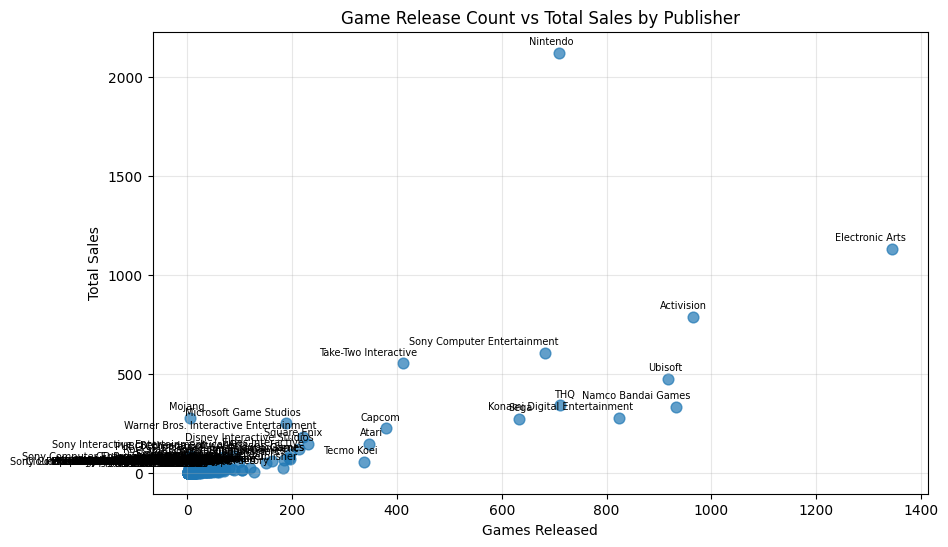

In [7]:
# A scatter chart can best visualize this relationship.

publisher_stats = df_sales.groupby('publisher').agg(
    game_count=('title', 'count'),
    total_sales=('global_sales', 'sum')
).reset_index()

analysis.publisher_scatter_plot(publisher_stats)


Like most entertainment industries, quality is more important than quantity. This is not to say that quantity doesn't matter. Look at Electronic Arts, with over 1,300 unqiue games, their sales are 2nd highest, but statistically compared to other publishers, their sales should be much higher. For example, Nintendo has almost half as many games as Electronic Arts, but double the sales. Most publishers have a predictable game count to sales ratio, but of course, there are outliers. When publishers consistently produce quality, influential games, quantity has less of an effect on total sales. Based on this data, game distributors should acknowledge that every new Nintendo game needs high stock levels, while most new EA games won't require as much stock.

##### **SQL Query #2:** What can we infer from a game's wishlist count?

Gamers often mark, or "wishlist", games as something they want to purchase in the future. If a game accumulates a large number of wishlists, it implies that there is a strong interest in that game. 

Despite a large wishlist count, a game can still have low sales. Low sales indicate that these games are either:
- Not readily available in the market (potential stock issue).
- Not priced competitively or marketed effectively.
- Experiencing delays in customer purchasing behavior (e.g., waiting for sales or bundles).

Low sales on high-wishlist games is an unmet demand that distributors should capitalize on. 

In [8]:
# Let's find out which games have high wishlist counts but low sales
rows = sql_queries.wishlist_analysis(cursor)
wishlist_analysis = pd.DataFrame(rows, columns=['Title', 'Wishlist Count', 'Total Sales'])
wishlist_analysis

,Title,Wishlist Count,Total Sales
0,Elden Ring,4800,25.53
1,Hades,3600,0.99
2,Stray,3400,5.91
3,Bloodborne,3300,2.38
4,Kirby and the Forgotten Land,3100,7.52
5,Cyberpunk 2077,2900,26.01
6,Red Dead Redemption 2,2900,61.56
7,God of War,2600,4.45
8,Cuphead,2600,8.78
9,The Legend of Zelda: Breath of the Wild,2600,32.39


Distributors should focus on stocking games on this list in higher volumes, or applying discounts to them, in order to make them more attainable for customers. Our findings corroborate with real-world examples. Elden Ring is currently on sale in multiple stores due to its high price point on Steam, but sustained popularity.

##### **SQL Query #3:** Which genres are popular?
Different players gravitate toward specific genres based on their preferences, gaming habits, and even emotional needs. In the next few queries, we will identify a pattern of how genres become popular. Based on this pattern, publishers may choose to release genre-trendy games, or distributors will increase genre-specific stock.

In [9]:
# First, let's calculate the total global sales for each genre.
rows = sql_queries.sales_by_genre(cursor)
sales_by_genre = pd.DataFrame(rows, columns=['Genre', 'Total Sales'])
sales_by_genre

,Genre,Total Sales
0,Action,1908.71
1,Sports,1335.70
2,Role-Playing,1243.00
3,Shooter,1213.92
4,Platform,895.51
5,Racing,791.02
6,Misc,766.14
7,Fighting,479.19
8,Simulation,465.53
9,Sandbox,359.78


Now let's join sales data with metadata to get additional insights such as average rating and number of reviews per genre. Why do these genres have such high sales?

In [10]:
rows = sql_queries.genre_comparisons(cursor)
genre_comparisons = pd.DataFrame(rows, columns=['Genre', 'Total Sales', 'Average Rating', 'Number of Reviews'])
genre_comparisons

,Genre,Total Sales,Average Rating,Number of Reviews
0,Action,1908.71,3.63,35344
1,Sports,1335.70,3.59,2511
2,Role-Playing,1243.00,3.86,29894
3,Shooter,1213.92,3.55,25064
4,Platform,895.51,3.63,27627
5,Racing,791.02,3.58,5643
6,Misc,766.14,3.57,2640
7,Fighting,479.19,3.38,5292
8,Simulation,465.53,3.55,3682
9,Sandbox,359.78,4.15,3


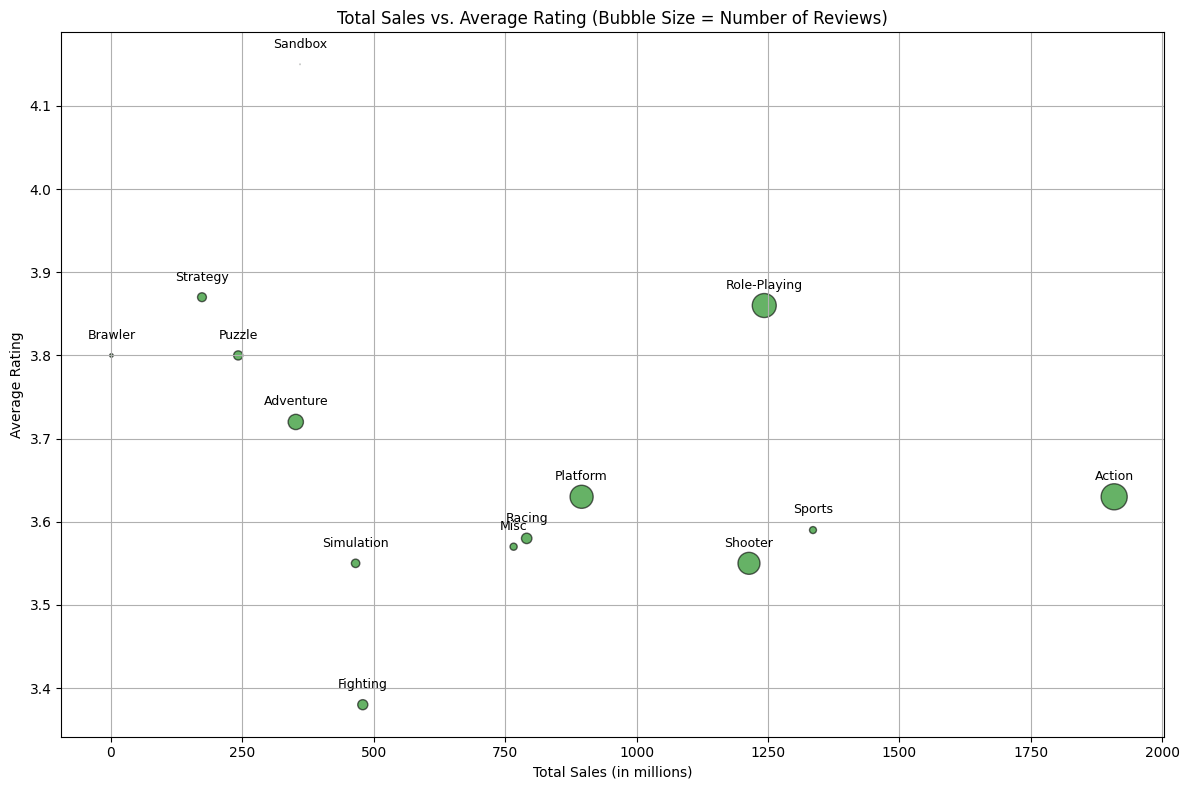

In [11]:
# This relationship can better be represented with a bubble chart
analysis.genre_bubble_chart(genre_comparisons)

Note the high sales-to-reviews ratio for genres like Action, Sports, and Role-Playing. These genres generate a lot of sales without necessarily receiving a high number of reviews. This can indicate a high volume of sales from casual players who may not leave reviews as often. If a publisher wants to push out a low-stakes game, they can consider a genre like Sports, a genre that's not as heavily scrutinized as say, RPG games.

The Sandbox genre stands out due to its very high rating (4.15) despite having little reviews. There are not many Sandbox games on the market (in part due to their difficulty to develop), but the few that are are quite successful (e.g. Minecraft, Terraria, No Man's Sky). The Sandbox genre could represent a niche with strong potential. It would be a good investment for developers to take on a Sandbox game.

Genres like Racing, Platform, and Simulation have moderate sales and ratings, indicating steady performance but not necessarily standout results in either category. These might represent genres that are stable but could benefit from innovation or a more engaged community. Platform is a difficult genre to innovate, however, because it has hit the ceiling in terms of creativity. Publishers need to be extremely creative if deciding to push out a Platform game. 

To finalize this query, let's make the data more digestable for video game distributers and publishers by generating a correlation between sales and reviews.

In [12]:
rows = sql_queries.genre_correlation(cursor)
genre_correlation = pd.DataFrame(rows, columns=['Genre', 'Sales per Review Correlation'])
genre_correlation

,Genre,Sales per Review Correlation
0,Action,0.054
1,Sports,0.532
2,Role-Playing,0.042
3,Shooter,0.048
4,Platform,0.032
5,Racing,0.140


By analyzing each genre's sales and reviews as a correlation, publishers and distributors can make more confident decisions.
- High, positive correlation (close to 1): The two metrics are closely related. More sales mean more reviews. If a game sells 100 copies, it gets 10 reviews; if it sells 200 copies, it gets 20 reviews. Both increase together.
- Low or no correlation (close to 0): The two metrics are not related. If a game has 100 sales but a 5-star rating, and another game has 1000 sales but a 2-star rating, there’s no clear link between ratings and sales.
- Negative correlation (close to -1): If more reviews actually lead to lower sales (which is rare), that’s a negative correlation.

---
### **Part 3: In-Depth Genre Analysis**

We will highlight the importance of genres in the video game market by continuing our genre analyis through DataFrame manipulation and predictive modeling.


sportsDf has an average global_sales of 0.579228100607112
sportsDf has a length of 2306
platformDf has an average global_sales of 1.0118757062146893
platformDf has a length of 885
racingDf has an average global_sales of 0.645730612244898
racingDf has a length of 1225
rpgDf has an average global_sales of 0.8325519089082385
rpgDf has a length of 1493
puzzleDf has an average global_sales of 0.4271252204585538
puzzleDf has a length of 567
miscDfNM has an average global_sales of 0.45603571428571427
miscDfNM has a length of 1680
shooterDf has an average global_sales of 0.9439502332814931
shooterDf has a length of 1286
simDf has an average global_sales of 0.5463967136150235
simDf has a length of 852
actionDf has an average global_sales of 0.5882003081664098
actionDf has a length of 3245
fightingDf has an average global_sales of 0.5725089605734767
fightingDf has a length of 837
adventureDf has an average global_sales of 0.27223684210526317
adventureDf has a length of 1292
strategyDf has an av

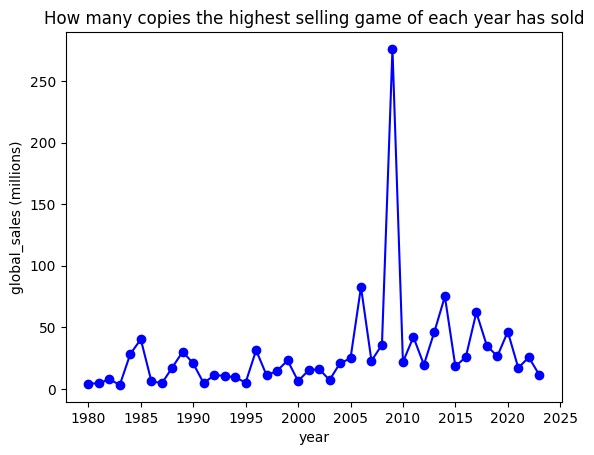

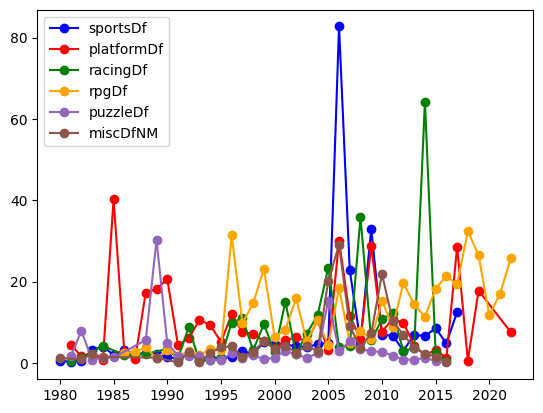

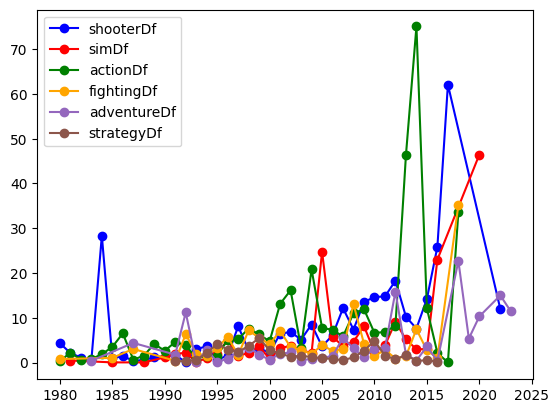

In [13]:
analysis.genre_sales_analysis(df_sales)

<Axes: xlabel='year'>

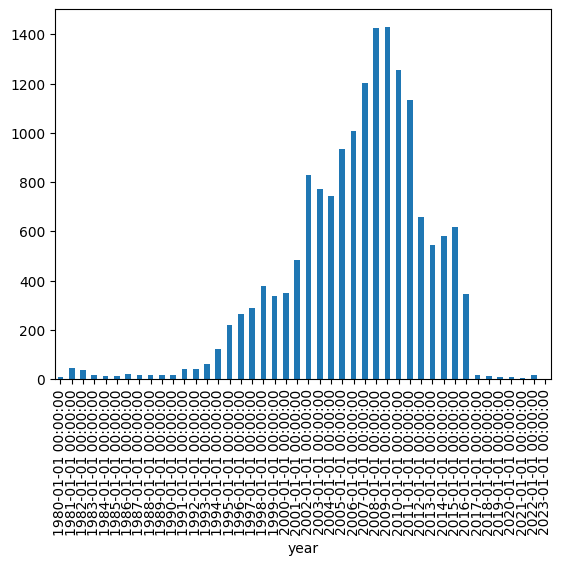

In [14]:
# Plot of how many games are in the dataset for each year
GPY = df_sales.groupby('year').size()
GPY.plot(kind = 'bar', x='year', y='0')

In [15]:
# General thoughts are:
# RPGs have solid, consistent sales numbers
# Platformers can perform quite well, but only in certain years... Wonder why? (It's probably Mario)
# What in the world happened to sports games in 2006?
# Or racing games in 2014? (It's probably Mario (Kart))
# Action, shooter, and simulation games seem to have heavy hitters. What are they and why do they sell well?

Here's a general trend of the highest selling game for every year. It may look like general sales are going down, but it's important to remember this is a trend for the highest selling game per year. What this could mean is that less games appeal to a majority of people, because there are so many games of differing styles available nowadays. Additionally, recent games have simply had less time to sell, which means that there's still potentially a few million sales left for these popular games.

Another, simpler explanation is just that recent years have less data in them for the dataset we're using, and as such, are missing games that could have sold the most copies (although I've personally checked, and the numbers seem correct). We can't really do anything about that besides manually entering in the highest selling games ourselves, since there's no publicly available way to get the sales data for a significant amount of games.

For reference, the game in 2009 that's sold 300 million copies is Minecraft. Minecraft is a very popular game. For the sake of other graphs, I've made them using new dfs that don't have minecraft so they don't get their scaling skewed towards the hundreds of millions.


![highest_selling_game_per_year.png](./images/highest_selling_game_per_year.png)

Here are some other graphs I used to to find trends in the highest selling games for each genre. I put 6 genres per graph so that there are less graphs to look at, and I still have some general idea of how different trends and genres compare to each other. I chose 6 per graph because it allows me to spot trends while not having to generate or look at too many graphs.

From here, we'll choose a specific few genres to look at.

![highest_selling_genre_1.png](./images/highest_selling_genre_1.png)

![highest_selling_genre_2.png](./images/highest_selling_genre_2.png)

From these graphs, I've made a select few observations

1 - RPGs have solid, consistent sales numbers. Why?

2 - Platformers can perform quite well, but only in certain years... Wonder why? (It's probably Mario)

3 - What in the world happened to sports games in 2006?

4 - Or racing games in 2014? (It's probably Mario (Kart))

5 - Action, shooter, and simulation games seem to have heavy hitters (in some years they sell much better than other years). What are they and why do they sell well?

In [16]:
rows = sql_queries.best_selling_genre_per_year(cursor).fetchall()
bestSellersDf = pd.DataFrame(rows, columns=['title', 'year', 'global_sales', 'genre'])
bestSellersDf

,title,year,global_sales,genre
0,Asteroids,1980-01-01 00:00:00,4.31,Shooter
1,Pitfall!,1981-01-01 00:00:00,4.50,Platform
2,Pac-Man,1982-01-01 00:00:00,7.81,Puzzle
3,Baseball,1983-01-01 00:00:00,3.20,Sports
4,Duck Hunt,1984-01-01 00:00:00,28.31,Shooter
5,Super Mario Bros.,1985-01-01 00:00:00,40.24,Platform
6,The Legend of Zelda,1986-01-01 00:00:00,6.51,Action
7,Zelda II: The Adventure of Link,1987-01-01 00:00:00,4.38,Adventure
8,Super Mario Bros. 3,1988-01-01 00:00:00,17.28,Platform
9,Tetris,1989-01-01 00:00:00,30.26,Puzzle


So just with this alone we've solved some questions.

Question 1:
We now know the reason why RPGs have such strong sales is because of Pokemon, as well as a unique mix of other popular RPGs. RPGs are typically longer than other games, which means they need more time to develop, giving them an uneven release schedule. So Pokemon's consistency as well as a few other strong batters (The Witcher 3, Hogwarts Legacy) are what give RPGs their strong sales numbers.

Question 3:
What happened to sports games in 2006 is Wii Sports. Wii Sports turned a niche (at the time) genre like sports and turned it into a family accessible and easy to get into game. The reason why sports games were so niche, and didn't sell as well as other games, is because the overlap between sports fans and video game fans was quite small. Nowadays, video games are more popular than ever, making more sports fans also game fans, giving modern sports games an existing fanbase to capitalize on (modern sports games release yearly, with no significant changes, and yet they still sell well every time. That's the power of a large existing fanbase).

Wii Sports turned an inaccessible, unappealing genre (at the time) on its head by marketing not to diehard fans of both but rather to passing fans of either. Its low barrier of entry made it so that anybody who thought it was an appealing game could easily get into it, no matter what their former interests were. This is the start of a trend I think we'll notice heavily, and have already started to notice, where games that are easy to get into, or that tap into an existing market, sell the best.

Question 5:
The reason why action games sell so well is because of the Grand Theft Auto series. Nearly no other series sell anywhere near as well as GTA games do. GTA is the best selling games in 4 different years. The only series with comparable numbers are Pokemon, Mario, and the Legend of Zelda (which somehow has 3 different games be the best selling of their years, all before 2000, and none after 2000). GTA V was the best selling game 2 years in a row (because it got released on different consoles during different years)! 

As for shooters, there isn't really one series that causes their sales, but rather the fact that they had something of a Renaissance during the mid 2010s. The three best selling shooter games of that decade aren't long running series, they're just games that were made well because they were made during a time period when they were very in demand.

This Renaissance decidedly ended with the release of Fortnite, which for some reason hasn't appeared on this list but has sold 350 million copies (from the sources I've found, at least). It is a free game, which may have inflated that sales number quite a bit (because if something is free, you aren't really "selling" it). But still, since its release in 2017, Fortnite has easily cornered the shooter market. I can't find sources that agree on how much it has grossed, but every estimate I see states fortnite has grossed at least tens of billions. To put this in perspective, fortnite has been the highest grossing game almost every year, if not every year, since it has released.

---

Some things I've noticed about good selling games:
From what I've seen, great selling games fall into 1 of 2 categories:

1 - They're part of either a long running, popular series/ are in a popular genre (usually these games have lots of funding put into them and release at the perfect time to capitalize on market trends) (Examples of this are GTA, Pokemon, the Witcher 3, and all the shooters released in the mid 2010s)

2 - They have low barriers to entry in some way (Either are simple games or cheap/free or are simple and/or appeal to a large existing consumer base) (Examples of this are Minecraft, also Pokemon, Fortnite, Minecraft, Wii Sports, Mario Kart, Mario, Animal Crossing, Nintendogs, Hogwarts Legacy, maybe Spider-Man 2)

Quite importantly, I don't think any of these games besides maybe The Witcher and the GTA games won GOTY, and many didn't achieve notoriety in gaming spheres. What I think this suggests is that "good" games like Elden Ring, Sekiro, The Last of Us and its sequel, The Legend Of Zelda: Breath of The Wild, and others may be too complex to achieve widespread appeal. As someone who's into games myself, I've heard that Elden Ring is the best game ever constantly for nearly 3 years straight. Yet somehow, it got outsold by Hogwarts Legacy, which I forgot existed. I think even the people who played it forgot it existed.

For the year of 2024, the best selling game is slated to be College Football '25. This may seem surprising, but it's the first College Football game in years, and so it's sold in droves to people who are huge fans of college football and desperate to play as their favorite teams. This can be classified as some combination of appealing to an existing fanbase, taking advantage of trends and timing, and having a somewhat low barrier of entry (most people know football in some capacity). 2nd, 3rd, and 4th are slated to be some combination of Dragon Ball Sparking Zero (taking advantage of a large existing fanbase just like Hogwarts Legacy did), Helldivers 2 (well funded and developed game in the popular shooter genre that's finally regaining its wings after oversaturation, distinct from Fortnite in its grittiness), and Call of Duty 6 (similar case to Helldivers 2), and the rest are mostly sports games (existing fanbase as well).

To end this off, I think the games that end up as lightning as a bottle do so by appealing to people that don't typically buy video games, or buy the genre the game is in (examples are Wii Sports, Pokemon back when it started, College Football, Mario Kart, maybe Minecraft and Terraria, and maybe Hogwarts Legacy). The best way to sell more copies seems to be to appeal to as many people as possible, which somewhat flies in the face of the trend of games becoming more and more unique and niche in recent years.

What's next up is potentially answering a few questions I have remaining, as well as trying to make a prediction model to predict various things, like how many games will release in a specific month or year.

In [17]:
# This is just a bit of code to check for correlations
# It will allow us to see what markets/ regions are most important for video games to sell well in
# If they want to sell well overall globally

# make a new df of only the numerical data
df_new = pd.DataFrame()
df_new['global_sales'] = df_sales['global_sales']
df_new['na_sales'] = df_sales['na_sales']
df_new['jp_sales'] = df_sales['jp_sales']
df_new['eu_sales'] = df_sales['eu_sales']
df_new['other_sales'] = df_sales['other_sales']


correlations = df_new.corr()['global_sales']
print(correlations)


# From here we see that north american and european sales are the most heavily correlated with global sales
# This makes sense, as both are heavily populated markets mostly comprised of well to do consumers

# Maybe this also has to do with how japanese work culture is too intense for a hobby such as video games
# Or how japan has less children than other areas, and since children are the biggest demographic for video games
# Japan has a lower amount of the most important demographic for high video game sales

# Another explanation is that for a game to become global it first needs to be popular in japan
# But not all games that are popular in japan go global
# As a result, some games that are popular in japan never tap in to global markets, diminishing their global sales
# And decreasing the correlation between sales in japan and sales overall as a result

global_sales    1.000000
na_sales        0.800288
jp_sales        0.556188
eu_sales        0.797168
other_sales     0.675080
Name: global_sales, dtype: float64


In [22]:
df_dropped = df_metadata.copy(deep=True)

# Using regex here to remove all rows with a release_date value that isn't a date
# I inspected the data and found all data that didn't have a date value in release_date
# Instead had 'release date TBD', and so to simplify the regex I checked only to remove rows that started with 'release'
df_dropped['release_date'] = df_dropped['release_date'].replace(to_replace=r'(release.*)', value=pd.NA, regex=True)

df_dropped_r = df_dropped.dropna(subset='release_date').copy()

print('the length of df_dropped is', len(df_dropped))
print('the length of df_dropped_r is', len(df_dropped_r))

df_dropped_r['release_date'] = pd.to_datetime(df_dropped_r['release_date'])

df_dropped_r['year'] = df_dropped_r['release_date'].dt.year
df_dropped_r['month'] = df_dropped_r['release_date'].dt.month
df_dropped_r['year_month'] = pd.to_datetime(df_dropped_r[['month', 'year']].assign(DAY=1))

the length of df_dropped is 1512
the length of df_dropped_r is 1509


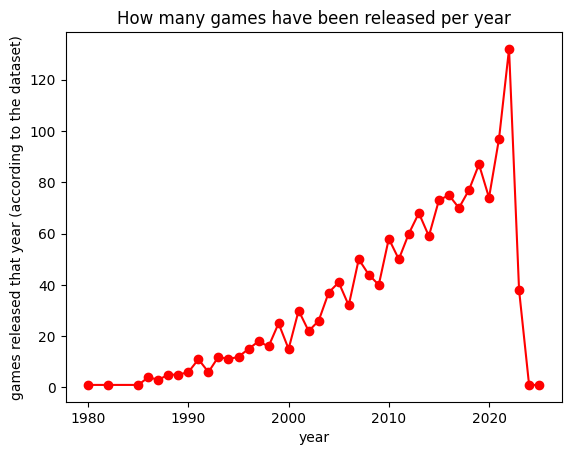

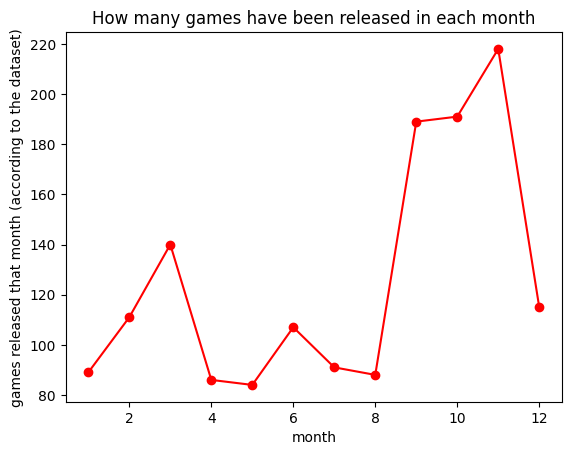

In [19]:
df_dropped_count_y = df_dropped_r.groupby('year')['title'].count().reset_index()
df_dropped_count_m = df_dropped_r.groupby('month')['title'].count().reset_index()

plt.plot(df_dropped_count_y['year'], df_dropped_count_y['title'], marker = 'o', color = 'red')
plt.title('How many games have been released per year')
plt.xlabel('year')
plt.ylabel('games released that year (according to the dataset)')
plt.show()

plt.plot(df_dropped_count_m['month'], df_dropped_count_m['title'], marker = 'o', color = 'red')
plt.title('How many games have been released in each month')
plt.xlabel('month')
plt.ylabel('games released that month (according to the dataset)')
plt.show()

# For years: We see a steady growth rate, as we should since video games as a whole have consistently grown in popularity
# The most recent year, 2023, has a dip, but that's just because the whole year isn't acocunted for in the dataset

# For months: We see a strong trend towards more games being released in the fall months of the year
# This is likely to capitalize on strong Christmas sales
# Video games are mostly played by children, so releasing games in November make it more likely for
# Children to be able to get them for Christmas
# A similar trend happens in movies, where many Christmas movies release either in November or many weeks before Christmas

---
### **Part 4: Predictive Modeling**

We will use our understanding of genres to predict genre sales in the future.

In [ ]:
# First, let's prepare the data for modeling.
# The df_dropped_r column 'plays' has values in the format of 2.1K, for example, so we need to change it to floats.
df_dropped_r = df_dropped_r[df_dropped_r['plays'].notna() & (df_dropped_r['plays'] != '')]
df_dropped_r['plays'] = df_dropped_r['plays'].apply(lambda x: float(float(str(x).replace('K', '')) * 1000) if 'K' in str(x) else int(x))


df_dropped_r['rating'] = pd.to_numeric(df_dropped_r['rating'], errors='coerce')
df_dropped_r = df_dropped_r[df_dropped_r['rating'].notna() & (df_dropped_r['rating'] != '')]
df_dropped_r['rating'] = df_dropped_r['rating'].astype(float)

correlation = df_dropped_r['plays'].corr(df_dropped_r['rating'])
print(correlation)

# Surprisingly, review score barely has any correlation with number of plays. Could be a failure of the dataset
# But it also could mean that making a great game (as decided by critics) doesn't mean people will play your game
# Maybe popular games have more people playing them, and so mor epeople who dislike them, and as such rate them badly
# As such, we still think being accessible is more important than focusing on making the perfect game when it comes
# To selling as many copies as possible

# Where physical retailers fit in here is that they caan do things to make games more accessible
# Providing value to both the publisher they buy from (increased reach) and the customer they sell too (more options)

0.20682145630258145


0.7972143065387051


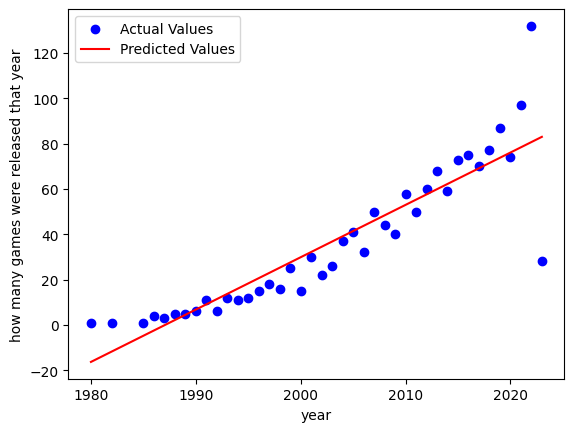

0.04098863716034862


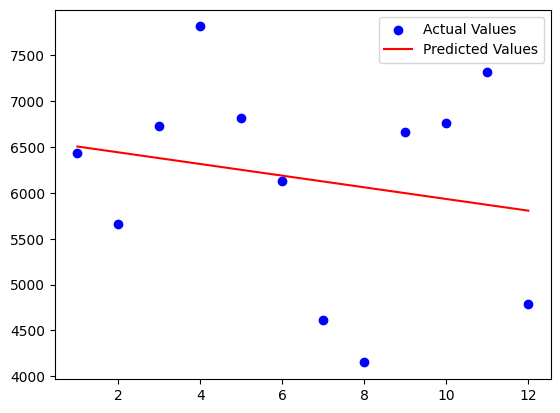

In [21]:
testModel1 = LinearRegression()

df_dropped_r['plays'] = df_dropped_r['plays'].astype(float)

df_test_1 = df_dropped_r.copy(deep=True)

# print(df_test_1.columns)

df_dropped_count_y = df_test_1.groupby('year')['title'].count().reset_index()
df_dropped_mean_m = df_test_1.groupby('month')['plays'].mean().reset_index()

# testModel1 predicts how many games will be released in a specified year
# It has an R^2 of about .8, meaning that's it's a very good model for predicting how many games will release in a year
model1X = df_dropped_count_y[['year']]
model1Y = df_dropped_count_y['title']

testModel1.fit(model1X, model1Y)

predictions1 = testModel1.predict(model1X)
r_square1 = r2_score(model1Y, predictions1)
print(r_square1)

plt.scatter(df_dropped_count_y['year'], model1Y, color='blue', label='Actual Values')
plt.plot(df_dropped_count_y['year'], predictions1, color='red', label='Predicted Values')
plt.xlabel('year')
plt.ylabel('how many games were released that year')
plt.legend()
plt.show()

# testModel2 predicts the average plays of games given month of release
# It has an R^2 of .07, meaning it's not a good predictor of how a game's release date will influence its plays
# Perhaps this means there isn't a significant relationship between plays and release month
model2X = df_dropped_mean_m[['month']]
model2Y = df_dropped_mean_m['plays']
testModel2 = LinearRegression()

testModel2.fit(model2X, model2Y)

predictions2 = testModel2.predict(model2X)
r_square2 = r2_score(model2Y, predictions2)
print(r_square2)

plt.scatter(df_dropped_mean_m['month'], model2Y, color='blue', label='Actual Values')
plt.plot(df_dropped_count_m['month'], predictions2, color='red', label='Predicted Values')
plt.legend()
plt.show()